# Solving TSP with Deep Rerinforcement Learning#

The notebook implements an improvement-base DRL method for solving the TSP problem by iteratively improving a feasible solution.

The code is based on the following paper:

```
Wu, Y., Song, W., Cao, Z., Zhang, J. and Lim, A., 2019. Learning improvement heuristics for solving the travelling salesman problem.
```(https://arxiv.org/abs/1912.05784)

© National University of Singapore. All Rights Reserved.

## Prepare: Install dependencies
### Install with pip
* PyTorch>=1.1
* numpy
* tqdm
* cv2
* tensorboard_logger
* imageio (optional, for plots)

### One more thing
For the exception below from package tensorboard_logger,
```python
AttributeError: module 'scipy.misc' has no attribute 'toimage'
```
Please refer to [issue #27](https://github.com/TeamHG-Memex/tensorboard_logger/issues/27) to fix it.

In [16]:
import os
import json
import pprint

import torch
import torch.optim as optim
from tensorboard_logger import Logger as TbLogger
from torch.utils.data import DataLoader

from nets.critic_network import CriticNetwork
from train import train_epoch, validate
from nets.reinforce_baselines import CriticBaseline
from nets.attention_model import AttentionModel
from utils import torch_load_cpu, load_problem, get_inner_model, move_to
from utils.plots import plot_tour

import warnings
warnings.filterwarnings("ignore", category=Warning)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## load the settings for training


In [17]:
# load the run args
%run options

# Set the random seed
torch.manual_seed(opts.seed)

# Optionally configure tensorboard
tb_logger = None
if not opts.no_tensorboard:
    tb_logger = TbLogger(os.path.join(opts.log_dir, "{}_{}".format(opts.problem, opts.graph_size), opts.run_name))

if not os.path.exists(opts.save_dir):
    os.makedirs(opts.save_dir)

# Save arguments so exact configuration can always be found
with open(os.path.join(opts.save_dir, "args.json"), 'w') as f:
    json.dump(vars(opts), f, indent=True)

 # Set the device
opts.device = torch.device("cuda" if opts.use_cuda else "cpu")

The default settings:
```
Runinig:
    devices: GPU if avaliable else CPU
    logging to tensorboard: True
    logging figures: True
    seed used: 1
    
Problem:
    TSP size: 20 nodes
    step method: 2-opt
    checking feasibility for each step: True
    
network:
    embedding_dim: 128
    hidden_dim: 128
    n_encoder_layers: 3
    n_heads_encoder: 1
    n_heads_decoder: 1
    normalization: batch
    
training:
    batch_size: 5120
    epoch_size: 51200
    number of epochs to train: 100
    T_max: 200
    n_step: 4
    gamma: 0.99
    learning_rate_init: 1e-4
    learning_rate_decay: 0.99
    
validating:
    dataset: './datasets/tsp_20_10000.pkl'
    batch_size: 1000
    T_max: 1000
```

### Simplify the training only for demonstration purpose
Current setting requires GPUs for efficient learning.
It takes around 8 hours on a single GeForce RTX 2080 Ti GPU card.

We simplify the settings by reducing the batch size and the epoch size for demo purpose.

Please skip this step for a real training.

In [18]:
# Please skip this for a real training.
opts.epoch_size = 32
opts.batch_size = 16
opts.val_size = 10
opts.eval_batch_size = 10

## Figure out what's the problem

In [19]:
problem = load_problem(opts.problem)(
                        p_size = opts.graph_size, # tsp size
                        with_assert = not opts.no_assert) # if checking feasibiliy

TSP with 20 nodes.


## Initialize our policy network

In [20]:
model_class = {
    'attention': AttentionModel,
}.get(opts.model, None)
assert model_class is not None, "Unknown model: {}".format(model_class)
                                                           
model = model_class(
    problem = problem,
    embedding_dim = opts.embedding_dim,
    hidden_dim = opts.hidden_dim,
    n_heads = 1, # can increase for better performance
    n_layers = opts.n_encode_layers,
    normalization = opts.normalization,
    device = opts.device,
).to(opts.device)

if opts.use_cuda and torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
    
model

AttentionModel(
  (embedder): EmbeddingNet(
    (embedder): Linear(in_features=2, out_features=128, bias=True)
  )
  (encoder): Sequential(
    (0): MultiHeadAttentionLayer(
      (0): SkipConnection(
        (module): MultiHeadAttention()
      )
      (1): Normalization(
        (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): SkipConnection(
        (module): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (3): Normalization(
        (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MultiHeadAttentionLayer(
      (0): SkipConnection(
        (module): MultiHeadAttention()
      )
      (1): Normalization(
        (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Initialize our critic network

In [21]:
baseline = CriticBaseline(
                CriticNetwork(
                    problem = problem,
                    embedding_dim = opts.embedding_dim,
                    hidden_dim = opts.hidden_dim,
                    n_heads = 1, # can increase for better performance
                    n_layers = opts.n_encode_layers,
                    normalization = opts.normalization,
                    device = opts.device,
                ).to(opts.device)
        )
baseline.critic

CriticNetwork(
  (embedder): EmbeddingNet(
    (embedder): Linear(in_features=2, out_features=128, bias=True)
  )
  (encoder): Sequential(
    (0): MultiHeadAttentionLayer(
      (0): SkipConnection(
        (module): MultiHeadAttention()
      )
      (1): Normalization(
        (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): SkipConnection(
        (module): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (3): Normalization(
        (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MultiHeadAttentionLayer(
      (0): SkipConnection(
        (module): MultiHeadAttention()
      )
      (1): Normalization(
        (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

 ## Initialize the Adam optimizer and learning rate scheduler

In [22]:
# Initialize optimizer
optimizer = optim.Adam(
            [{'params': model.parameters(), 'lr': opts.lr_model}]
            + (
                [{'params': baseline.get_learnable_parameters(), 'lr': opts.lr_critic}]
                if len(baseline.get_learnable_parameters()) > 0 else []
            )
        )

# Initialize learning rate scheduler, decay by lr_decay once per epoch!
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: opts.lr_decay ** epoch)

optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 0.0001
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 0.0001
    weight_decay: 0
)

## Load the validation datasets

In [23]:
val_dataset = problem.make_dataset(size=opts.graph_size,
                                   num_samples=opts.val_size,
                                   filename = opts.val_dataset)

## Start training !!

Let's train 2 epochs with T=100 for example:

In [24]:
opts.T_train = 100
opts.n_epochs = 2
opts.epoch_start = 0

for epoch in range(opts.epoch_start, opts.epoch_start + opts.n_epochs):
    train_epoch(
        problem,
        model,
        optimizer,
        baseline,
        lr_scheduler,
        epoch,
        val_dataset,
        tb_logger,
        opts
    )




| ********************* Training epoch 0 ********************* |
Training with lr=1.000e-04 for run run_name_20200730T131309


training: 100%|████████████████████| 50/50 [00:21<00:00,  2.30it/s]

Saving model and state...

Validating...



rollout: 100%|████████████████████| 1000/1000 [00:16<00:00, 59.43it/s]



 ------------------------------------------------------------
         Avg total reward:          4.241685   +- 0.332718  
          Avg step reward:          0.004242   +- 0.018454  
------------------------------------------------------------
           Avg init cost:           9.923937   +- 0.394804  
  Avg cost after 20% improvement:   7.812395   +- 0.356064  
  Avg cost after 40% improvement:   8.460790   +- 0.438866  
  Avg cost after 60% improvement:   7.955374   +- 0.452564  
  Avg cost after 80% improvement:   7.949316   +- 0.383378  
  Avg cost after 100% improvement:  7.953381   +- 0.340813  
           Avg best cost:           5.682251   +- 0.208888  
------------------------------------------------------------
           Avg used time:           1.683686s
------------------------------------------------------------ 




| ********************* Training epoch 1 ********************* |
Training with lr=9.900e-05 for run run_name_20200730T131309


training: 100%|████████████████████| 50/50 [00:21<00:00,  2.35it/s]

Saving model and state...

Validating...



rollout: 100%|████████████████████| 1000/1000 [00:16<00:00, 59.53it/s]



 ------------------------------------------------------------
         Avg total reward:          4.521887   +- 0.343700  
          Avg step reward:          0.004522   +- 0.016911  
------------------------------------------------------------
           Avg init cost:           9.923937   +- 0.394804  
  Avg cost after 20% improvement:   7.329743   +- 0.386100  
  Avg cost after 40% improvement:   7.252641   +- 0.287185  
  Avg cost after 60% improvement:   7.615552   +- 0.334616  
  Avg cost after 80% improvement:   7.065089   +- 0.304543  
  Avg cost after 100% improvement:  7.979433   +- 0.344634  
           Avg best cost:           5.402050   +- 0.164046  
------------------------------------------------------------
           Avg used time:           1.680866s
------------------------------------------------------------ 



## let's show the training logs with Tensorboard

In [10]:
logs_base_dir = os.path.join(os.getcwd(),'logs/tsp_20')

%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 49468), started 0:14:53 ago. (Use '!kill 49468' to kill it.)

## Let's see what an actual training looks like

In [11]:
# start a new tensorboard
logs_base_dir = os.path.join(os.getcwd(),'logs/pre_trained')
%tensorboard --logdir {logs_base_dir}

## We can load the pre-trained model

In [25]:
opts.load_path = './outputs/tsp_20/tsp_20200714T212735/epoch-99.pt'

# Load data from load_path
load_data = {}
assert opts.load_path is None or opts.resume is None, "Only one of load path and resume can be given"
load_path = opts.load_path if opts.load_path is not None else opts.resume
if load_path is not None:
    print('  [*] Loading data from {}'.format(load_path))
    load_data = torch_load_cpu(load_path)

# Overwrite model parameters by parameters to load
model_ = get_inner_model(model)
model_.load_state_dict({**model_.state_dict(), **load_data.get('model', {})})

  [*] Loading data from ./outputs/tsp_20/tsp_20200714T212735/epoch-99.pt


<All keys matched successfully>

### Validate using the loaded model

In [26]:
validate(problem, model, val_dataset, tb_logger, opts)


Validating...


rollout: 100%|████████████████████| 1000/1000 [00:15<00:00, 63.47it/s]



 ------------------------------------------------------------
         Avg total reward:          6.164712   +- 0.377554  
          Avg step reward:          0.006165   +- 0.019763  
------------------------------------------------------------
           Avg init cost:           9.923937   +- 0.394804  
  Avg cost after 20% improvement:   4.049284   +- 0.118281  
  Avg cost after 40% improvement:   3.942811   +- 0.109086  
  Avg cost after 60% improvement:   3.923949   +- 0.087778  
  Avg cost after 80% improvement:   4.093946   +- 0.136721  
  Avg cost after 100% improvement:  3.957371   +- 0.091912  
           Avg best cost:           3.759225   +- 0.084913  
------------------------------------------------------------
           Avg used time:           1.576713s
------------------------------------------------------------ 



## Let's look inside the model

Let's see what happens when solving a particular TSP instance.
### Get one TSP instance

In [27]:
instance = next(iter(DataLoader(val_dataset, batch_size = 1)))
instance

tensor([[[0.4509, 0.8512],
         [0.3281, 0.4170],
         [0.2536, 0.4560],
         [0.6566, 0.6865],
         [0.0264, 0.5931],
         [0.2647, 0.8877],
         [0.9084, 0.8208],
         [0.3501, 0.1872],
         [0.9299, 0.0127],
         [0.1770, 0.8813],
         [0.1611, 0.9836],
         [0.6462, 0.2009],
         [0.5012, 0.6662],
         [0.4446, 0.8552],
         [0.5352, 0.5726],
         [0.9432, 0.0668],
         [0.6561, 0.2709],
         [0.7097, 0.8725],
         [0.6250, 0.1875],
         [0.6853, 0.0979]]])

### Get one initial solution

In [33]:
solution = move_to(
        problem.get_initial_solutions('seq', instance), opts.device)

cost = problem.get_costs(instance, solution)

solution, cost

(tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
          14., 15., 16., 17., 18., 19.]]),
 tensor([10.4616]))

### Plot the initial solution


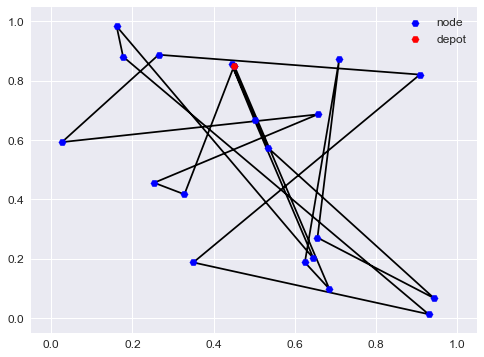

In [29]:
plot_tour(solution, instance[0])

### Pass through embedder only 

To show how embedder works, <br>
we can pass the instance and the tour through only the embedder of our policy network, <br>
and visualize the tour in the embedded space using PCA.

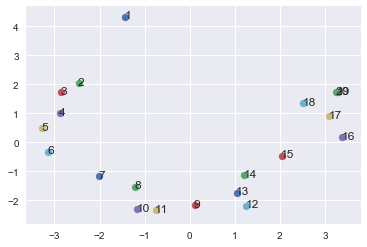

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19.]])

In [30]:
# the embedded input x
bs, gs, in_d = instance.size()

# pass through embedder: current solutions
x_embed = model.embedder(instance, solution)

# transform the high-dimensional data into two dimensions using PCA
from sklearn.decomposition import PCA
X = x_embed[0].detach().numpy()
pca = PCA(n_components=2)
pca.fit(X)
out = pca.transform(X)

# visualize the tour in the embedded space
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(20):
    ax.scatter(out[i,0], out[i,1])
    plt.annotate(i+1,(out[i,0] - 0.015, out[i,1] - 0.06), fontsize=12) 
ax.grid(True)

plt.show()
solution

### Pass through encoder and decoder

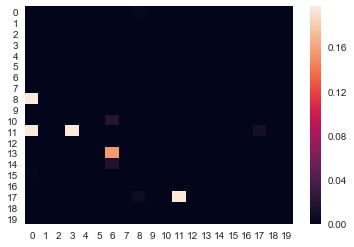

In [31]:
# pass through encoder: current solutions
h_em = model.encoder(x_embed) # torch.Size([2, 50, 128])

# get embed graph feature
max_pooling = h_em.max(1)[0] # max Pooling
graph_feature = model.project_graph(max_pooling)[:, None, :]

# get embed node feature
node_feature = model.project_node(h_em)

# pass through decoder, get log_likelihood and M matrix
fusion = node_feature + graph_feature.expand_as(node_feature) # torch.Size([2, 50, 128])
log_likelihood, M_value = model.decoder(fusion, None, solution) # att torch.Size([1, 2, 2500])          

# get the action table
M_value = M_value.detach().view(20,20)
M_value[problem.get_swap_mask(solution)[0].view(-1).view(20,20).bool()] = 0

# visulize the action table
import seaborn as sns; sns.set() 
sns.heatmap(M_value)
plt.show()

# After we get this table, we can sample an action for the next step.

### Solve this instance by rollout (T = 100)

rollout: 100%|████████████████████| 100/100 [00:01<00:00, 73.61it/s]


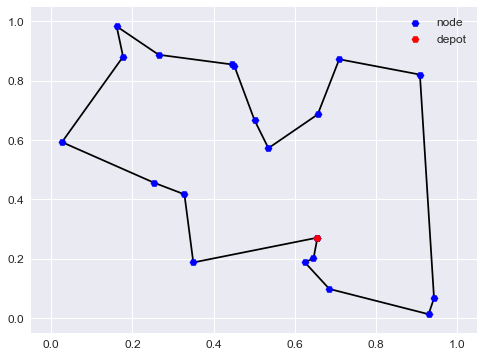

(tensor([16.,  7.,  1.,  2.,  4.,  9., 10.,  5., 13.,  0., 12., 14.,  3., 17.,
          6., 15.,  8., 19., 18., 11.]),
 tensor([[3.7876]]))

In [34]:
from train import rollout
x_input = move_to(instance, opts.device) # batch_size, graph_size, 2
batch = move_to(instance, opts.device) # batch_size, graph_size, 2

model.eval() # change to eval mode
best_val, improvement, reward, history_solutions = rollout( problem, 
                                                             model, 
                                                             x_input, 
                                                             instance, 
                                                             solution, 
                                                             cost, 
                                                             opts, 
                                                             100,
                                                             True,
                                                             True)

best_solution = history_solutions[0][-1,:]
plot_tour(best_solution, instance[0])

best_solution, best_val

### Visualize the improvement process

In [35]:
from utils.record_a_video import record_gif
record_gif(instance, history_solutions, filename = 'ep_gif', dpi = 60)


tour completed: 100%|██████████| 101/101 [00:14<00:00,  6.79it/s]A

record for each instance: 100%|██████████| 1/1 [00:14<00:00, 14.88s/it]


In [30]:
from IPython.display import HTML
HTML('<img src="outputs/ep_gif_0.gif">')

## Any Questions?